<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/mHealth/mHealth_ResNet%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
from scipy import stats

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten
)

In [3]:
DATA_DIR = "/content/drive/MyDrive/datasets/MHEALTHDATASET"
COLS = [
    "chest_acc_x", "chest_acc_y", "chest_acc_z", "ecg_lead1", "ecg_lead2",
    "lankle_acc_x", "lankle_acc_y", "lankle_acc_z", "lankle_gyro_x",
    "lankle_gyro_y", "lankle_gyro_z", "lankle_mag_x", "lankle_mag_y",
    "lankle_mag_z", "rarm_acc_x", "rarm_acc_y", "rarm_acc_z",
    "rarm_gyro_x", "rarm_gyro_y", "rarm_gyro_z", "rarm_mag_x",
    "rarm_mag_y", "rarm_mag_z", "label"
]

In [4]:
ACTIVITY_MAP = {
    0: "null", 1: "standing", 2: "sitting", 3: "lying", 4: "walking",
    5: "climbing_stairs", 6: "waist_bends_forward", 7: "frontal_arm_raise",
    8: "knees_bending", 9: "cycling", 10: "jogging", 11: "running",
    12: "jump_front_back"
}
SAMPLING_RATE = 50

In [5]:
WINDOW_SECONDS = 2.5 # 2.5초 길이의 윈도우
WINDOW_SIZE = int(WINDOW_SECONDS * SAMPLING_RATE)
STEP = WINDOW_SIZE // 2

In [6]:
FEATURES_COLS = [c for c in COLS if c != "label"]
NUM_FEATURES = len(FEATURES_COLS)
NUM_CLASSES = 12

In [7]:
#데이터 로드 및 전처리
files=sorted(glob.glob(os.path.join(DATA_DIR, "mHealth_subject*.log")))

In [8]:
dfs=[]
for f in files:
    tmp = pd.read_csv(f, delim_whitespace=True, header=None)
    tmp.columns = COLS
    tmp["subject"] = int(re.search(r"subject(\d+)", f).group(1))
    dfs.append(tmp)

/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipython-input-3411836070.py:3: FutureWarning: T

In [9]:
df_raw=pd.concat(dfs, axis=0, ignore_index=True)
df_raw.shape

(1215745, 25)

In [10]:
#null (레이블 0) 데이터 제외
df_activity=df_raw[df_raw["label"]!=0].copy()
df_activity['label']=df_activity['label']-1
df_activity.shape

(343195, 25)

In [11]:
sorted(df_activity['label'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11)]

In [12]:
#스케일링
#Train, test 분리 및 스케일링
train_subjects=[1, 2, 3, 4, 5, 6]
val_subjects=[7, 8]
test_subjects=[9, 10]

train_data=df_activity[df_activity['subject'].isin(train_subjects)].copy()
val_data=df_activity[df_activity['subject'].isin(val_subjects)].copy()
test_data=df_activity[df_activity['subject'].isin(test_subjects)].copy()

print(f"Train 데이터 shape: {train_data.shape} (Subjects: {train_subjects})")
print(f"Validation 데이터 shape: {val_data.shape} (Subjects: {val_subjects})")
print(f"Test 데이터 shape: {test_data.shape} (Subjects: {test_subjects})")

Train 데이터 shape: (207566, 25) (Subjects: [1, 2, 3, 4, 5, 6])
Validation 데이터 shape: (67585, 25) (Subjects: [7, 8])
Test 데이터 shape: (68044, 25) (Subjects: [9, 10])


In [13]:
#StandardScaler 적용
scaler=StandardScaler()
#scaler를 train data로만 fit 한다.
scaler.fit(train_data[FEATURES_COLS])

StandardScaler()

In [14]:
#스케일러 적용
train_data.loc[:, FEATURES_COLS] = scaler.transform(train_data[FEATURES_COLS])
val_data.loc[:, FEATURES_COLS] = scaler.transform(val_data[FEATURES_COLS])
test_data.loc[:, FEATURES_COLS] = scaler.transform(test_data[FEATURES_COLS])

In [15]:
#윈도우는 어떻게 잘라야할지?
def create_windows(data, window_size, step, features_cols, label_col='label'):
    X, y = [], []
    for subject, g in data.groupby('subject'):
        g = g.sort_index()
        segment = g[features_cols].values
        labels  = g[label_col].values
        n = len(g)
        for i in range(0, n - window_size + 1, step):
            win_y = labels[i : i + window_size]
            #최빈값을 라벨로
            win_label = stats.mode(win_y, keepdims=True)[0][0]
            X.append(segment[i : i + window_size])
            y.append(win_label)
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = create_windows(train_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_val, y_val = create_windows(val_data, WINDOW_SIZE, STEP, FEATURES_COLS)
X_test, y_test = create_windows(test_data, WINDOW_SIZE, STEP, FEATURES_COLS)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")

X_train shape: (3339, 125, 23) | y_train shape: (3339,)
X_val shape: (1087, 125, 23) | y_val shape: (1087,)
X_test shape: (1095, 125, 23) | y_test shape: (1095,)


### ResNet+Transformer Encoder

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten, Layer, Embedding, Activation
)

In [18]:
def resnet_block_1d(inputs, filters, kernel_size=5, downsample=False):
    strides = 2 if downsample else 1

    x = Conv1D(filters, kernel_size,
               strides=strides,
               padding="same",
               kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv1D(filters, kernel_size,
               strides=1,
               padding="same",
               kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    # 스킵 커넥션 (Skip Connection)
    skip = inputs

    # 1. 시퀀스 길이가 줄어들었거나 (downsample=True)
    # 2. 채널(필터) 수가 달라진 경우
    # 스킵 커넥션 경로에도 1x1 Conv를 적용하여 shape 맞춰주기....
    if downsample or (inputs.shape[-1] != filters):
        skip = Conv1D(filters, 1, # 1x1 Conv로 차원 맞추기
                      strides=strides, # 동일한 stride 적용
                      padding="same",
                      kernel_initializer="he_normal")(inputs)
        skip = BatchNormalization()(skip)

    # 주 경로와 스킵 커넥션 합산
    x = Add()([x, skip])
    x = Activation("relu")(x)
    return x

In [22]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [23]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])
  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)
  return Add()([attn_output, ffn_output])

In [24]:
def build_resnet_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2):

    inputs = Input(shape=input_shape)

    #ResNet 특징 추출기
    x = Conv1D(filters=32, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # (None, 63, 32)

    #ResNet Blocks
    x = resnet_block_1d(x, filters=32, downsample=True)
    x = resnet_block_1d(x, filters=32, downsample=False)
    # (None, 32, 32)

    #ResNet Block
    x = resnet_block_1d(x, filters=d_model, downsample=True)
    x = resnet_block_1d(x, filters=d_model, downsample=False)
    # (None, 16, 64)

    #Transformer 인코더
    seq_len_after_resnet = x.shape[1]
    x = PositionalEmbedding(seq_len=seq_len_after_resnet, d_model=d_model)(x)
    x = Dropout(0.1)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, d_model, num_heads, ff_dim)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [25]:
model_input_shape = (WINDOW_SIZE, NUM_FEATURES)

resnet_model = build_resnet_transformer(
    model_input_shape,
    num_classes=NUM_CLASSES,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2
)

In [26]:
# --- 모델 컴파일 ---
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 125, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 63, 32)    │      5,184 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 32)    │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 63, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 32, 32)    │      5,152 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 32, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 32, 32)    │      5,152 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 32, 32)    │      1,056 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 32, 32)    │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 32, 32)    │      5,152 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 32, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 32, 32)    │      5,152 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 32, 32)    │          0 │ batch_normalizat

 Total params: 175,852 (686.92 KB)

 Trainable params: 174,828 (682.92 KB)

 Non-trainable params: 1,024 (4.00 KB)

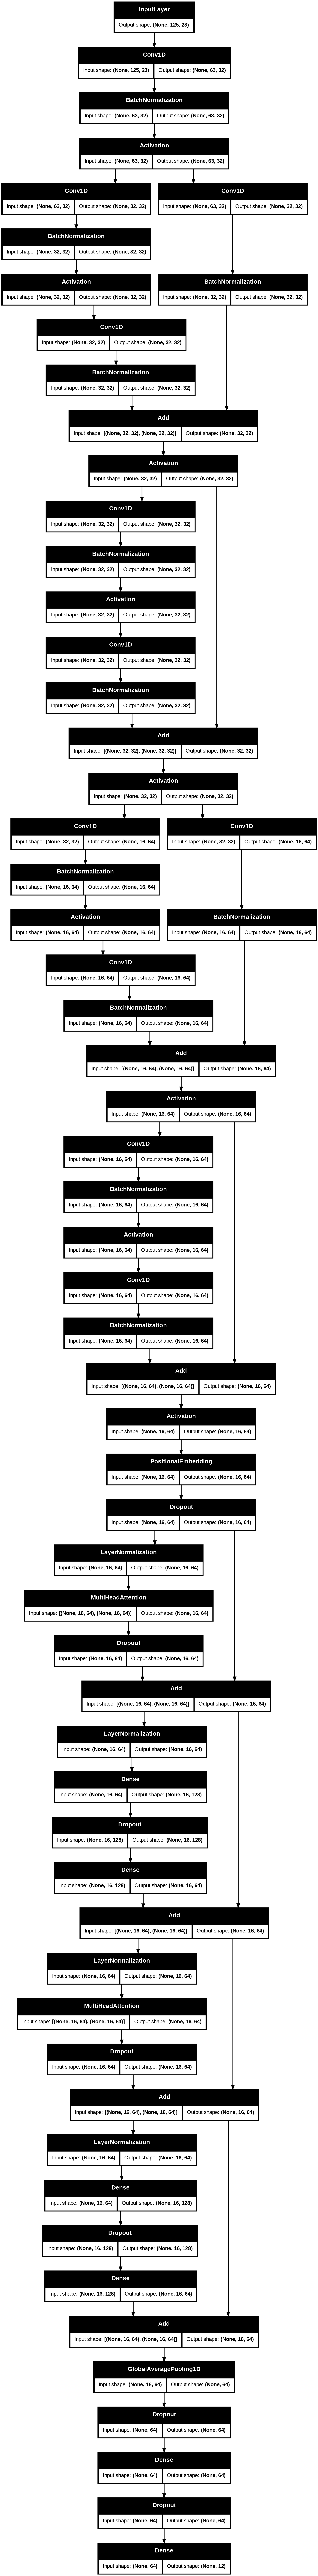

In [28]:
import tensorflow as tf
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

In [29]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
    )
]

In [32]:
history = resnet_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9220 - loss: 0.2295 - val_accuracy: 0.7866 - val_loss: 1.4701 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9704 - loss: 0.1139 - val_accuracy: 0.8390 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9697 - loss: 0.1211 - val_accuracy: 0.6983 - val_loss: 1.6344 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9684 - loss: 0.1391 - val_accuracy: 0.8160 - val_loss: 1.2085 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9712 - loss: 0.1087 - val_accuracy: 0.9172 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9830 - loss: 0.0565 - val_accuracy: 0.8933 - val_loss: 0.8679 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9816 - loss: 0.0506

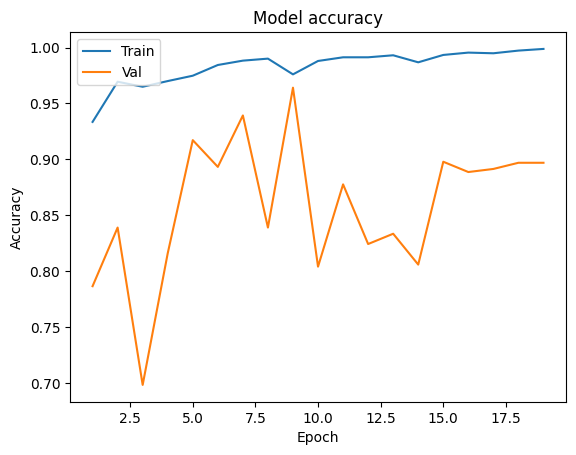

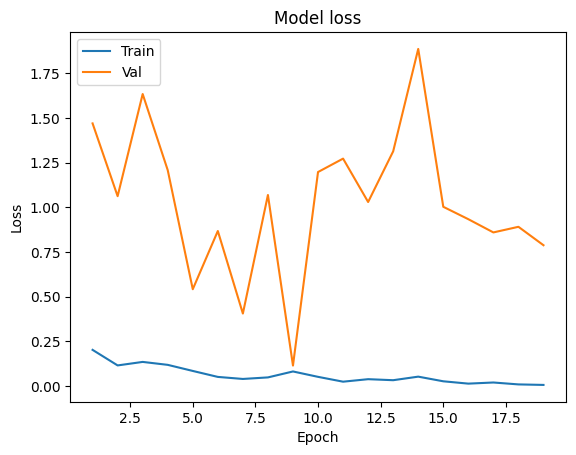

In [33]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 50)

In [34]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [35]:
# 2. Classification Report
y_pred = resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
target_names = [v for k, v in ACTIVITY_MAP.items() if k != 0]
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step

--- Classification Report ---
                     precision    recall  f1-score   support

           standing       1.00      1.00      1.00        99
            sitting       1.00      0.87      0.93        99
              lying       0.98      0.49      0.66        99
            walking       0.99      1.00      0.99        99
    climbing_stairs       0.99      0.99      0.99        98
waist_bends_forward       0.67      1.00      0.80        86
  frontal_arm_raise       0.88      1.00      0.94        90
      knees_bending       1.00      0.54      0.70        95
            cycling       1.00      1.00      1.00        99
            jogging       0.91      1.00      0.95        99
            running       1.00      0.90      0.95        99
    jump_front_back       0.40      1.00      0.57        33

           accuracy                           0.89      1095
          macro avg       0.90      0.90      0.87      1095
       weigh


--- Confusion Matrix (CBAM Model) ---


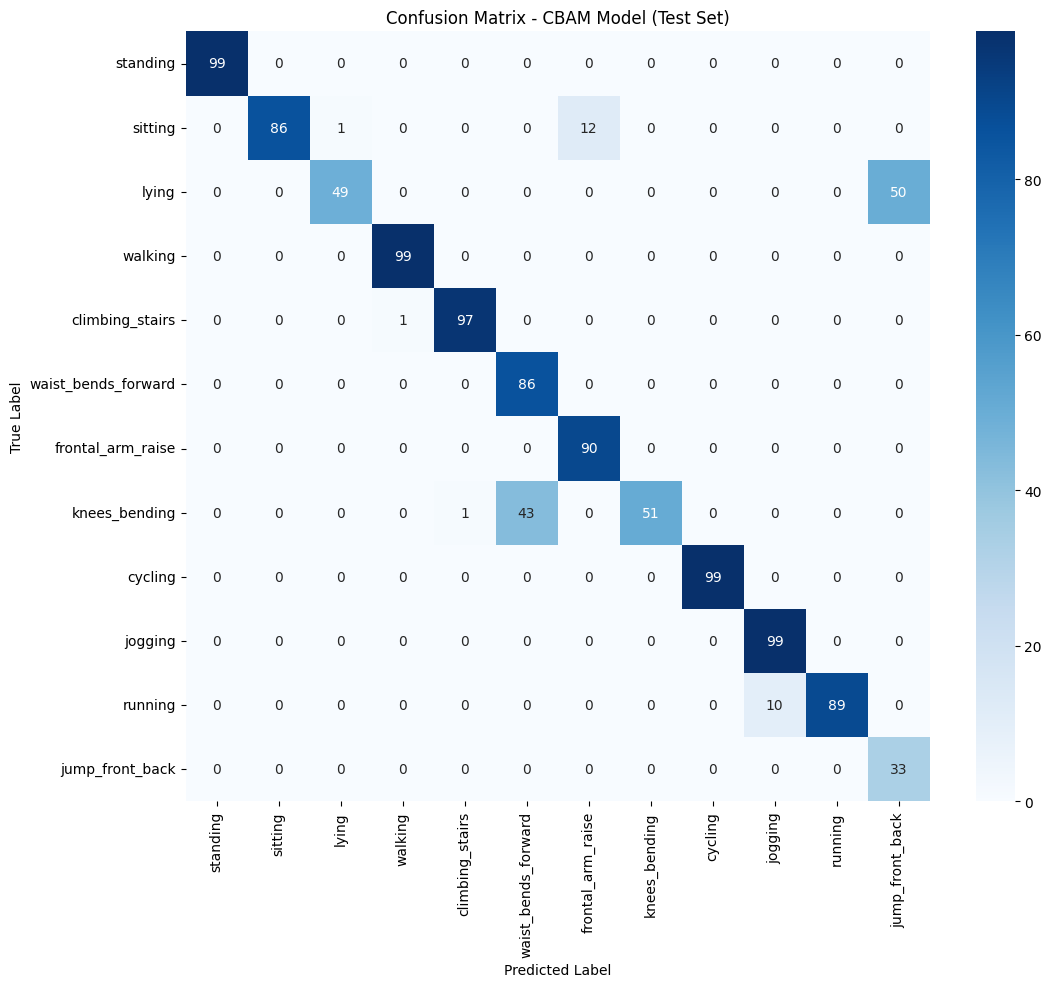

In [37]:
print("\n--- Confusion Matrix (CBAM Model) ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - CBAM Model (Test Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()